# Tournament simulation using PyStan

In this notebook, I build a simple Bayesian model to predict the outcome of the tournament. Since the bracket deadline is soon, I don't have time to add comments and there is plenty to clean up and improve. Comments are welcome!

Main idea: assign score $\alpha_i$ to each team, predict $\sqrt{\Delta}$ where $\Delta$ is the difference in scores using $\sqrt{\Delta} \approx \alpha_i - \alpha_j + h$ where $h$ is the home-field advantage.

We let $\alpha_i$ vary over time.

There is no validation, so use at your own risk, though the predictions do lack creativity so it must have captured some common trends.

Download the data from [Kaggle](https://www.kaggle.com/c/mens-machine-learning-competition-2018).

In [2]:
import random
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import pystan as ps

In [ ]:
first_season = 2012

In [ ]:
def convert_Wloc(loc):
    if loc == "H":
        return 1
    if loc == "A":
        return -1
    return 0

In [ ]:
rs_df = pd.read_csv("data_2018/RegularSeasonCompactResults.csv")
t_df = pd.read_csv("data_2018/NCAATourneyCompactResults.csv")

games = pd.concat((rs_df, t_df))
teams = pd.read_csv("data_2018/Teams.csv")
seeds = pd.read_csv("data_2018/NCAATourneySeeds.csv")
slots = pd.read_csv("data_2018/NCAATourneySlots.csv")

# team conversions
tid_to_id = { team: idx for idx, team in enumerate(teams["TeamID"].factorize()[1]) }
id_to_tid = { idx: team for idx, team in enumerate(teams["TeamID"].factorize()[1]) }

def tid_to_name(tid):
    return teams[teams.TeamID == tid].iloc[0].TeamName

def id_to_name(idx):
    return tid_to_name(id_to_tid[idx])

name_to_tid = {id_to_name(idx): id_to_tid[idx] for idx in range(len(teams))}

# create extra tables
games["win_id"] = games.apply(lambda x: tid_to_id[x.WTeamID], 1)
games["los_id"] = games.apply(lambda x: tid_to_id[x.LTeamID], 1)
games["athome"] = games.apply(lambda x: convert_Wloc(x.WLoc), 1)
games["period"] = np.minimum(games.DayNum // 45, 2)

games = games[games["Season"] >= first_season]

games["season"] = games.Season - first_season
games["dscore"] = np.sqrt(games.WScore - games.LScore)

In [5]:
games.groupby([games.Season, games.period]).count()

Season  DayNum  WTeamID  WScore  LTeamID  LScore  WLoc  NumOT  \
Season period                                                                  
2012   0         1480    1480     1480    1480     1480    1480  1480   1480   
       1         1981    1981     1981    1981     1981    1981  1981   1981   
       2         1859    1859     1859    1859     1859    1859  1859   1859   
2013   0         1651    1651     1651    1651     1651    1651  1651   1651   
       1         1922    1922     1922    1922     1922    1922  1922   1922   
       2         1814    1814     1814    1814     1814    1814  1814   1814   
2014   0         1638    1638     1638    1638     1638    1638  1638   1638   
       1         1917    1917     1917    1917     1917    1917  1917   1917   
       2         1874    1874     1874    1874     1874    1874  1874   1874   
2015   0         1523    1523     1523    1523     1523    1523  1523   1523   
       1         2008    2008     2008    2008     2008    2008  2008   2008   
       2         1890    1890     1890    1890     1890    1890  1890   1890   
2016   0         1535    1535     1535    1535     1535    1535  1535   1535   
       1         1973    1973     1973    1973     1973    1973  1973   1973   
       2         1928    1928     1928    1928     1928    1928  1928   1928   
2017   0         1568    1568     1568    1568     1568    1568  1568   1568   
       1         1959    1959     1959    1959     1959    1959  1959   1959   
       2         1935    1935     1935    1935     1935    1935  1935   1935   
2018   0         1567    1567     1567    1567     1567    1567  1567   1567   
       1         1973    1973     1973    1973     1973    1973  1973   1973   
       2         1865    1865     1865    1865     1865    1865  1865   1865   

               win_id  los_id  athome  period  season  dscore  
Season period                                                  
2012   0         1480    1480    1480    1480    1480    1480  
       1         1981    1981    1981    1981    1981    1981  
       2         1859    1859    1859    1859    1859    1859  
2013   0         1651    1651    1651    1651    1651    1651  
       1         1922    1922    1922    1922    1922    1922  
       2         1814    1814    1814    1814    1814    1814  
2014   0         1638    1638    1638    1638    1638    1638  
       1         1917    1917    1917    1917    1917    1917  
       2         1874    1874    1874    1874    1874    1874  
2015   0         1523    1523    1523    1523    1523    1523  
       1         2008    2008    2008    2008    2008    2008  
       2         1890    1890    1890    1890    1890    1890  
2016   0         1535    1535    1535    1535    1535    1535  
       1         1973    1973    1973    1973    1973    1973  
       2         1928    1928    1928    1928    1928    1928  
2017   0         1568    1568    1568    1568    1568    1568  
       1         1959    1959    1959    1959    1959    1959  
       2         1935    1935    1935    1935    1935    1935  
2018   0         1567    1567    1567    1567    1567    1567  
       1         1973    1973    1973    1973    1973    1973  
       2         1865    1865    1865    1865    1865    1865

In [6]:
len(games)

37860

# Simple Stan model

In [21]:
stan_code = """
data {
    int<lower=0> nteams; // number of teams
    int<lower=1> nseasons; // number of seasons
    int<lower=1> nperiods; // number of periods
    int<lower=0> N; // number of observations
    
    real dscore[N]; // Outcome
    int tid[N]; // Team
    int oid[N]; // Opponent
    int location[N]; // location of game
    int season[N]; // Season of game
    int period[N]; // Period in season
}
transformed data {}
parameters {
    real home_advantage;
    real team_initial[nteams];
    real dteam_seasons[nteams, nseasons-1];
    real team_periods[nteams, nseasons, nperiods];
    
    // evolution of teams
    real<lower=0.01> sigma_team0;
    real<lower=0.01> sigma_team_season;
    real<lower=0.01> sigma_team_period;
    
    // variance for home game advantage
    real<lower=0.1, upper=3> sigma_home;
    
    // variance in outcome
    real<lower=0.1, upper=5> sigma_score;
}
transformed parameters {
    vector[N] home_quality;
    vector[N] away_quality;
    vector[N] xb;
    
    real team_seasons[nteams, nseasons];
    
    for (t in 1:nteams) {
        team_seasons[t, 1] = team_initial[t];
        for (s in 2:nseasons) {
            team_seasons[t, s] = team_seasons[t, s-1] + dteam_seasons[t, s-1];
        }
    }
    
    for(i in 1:N) {
        home_quality[i] = team_seasons[tid[i], season[i]] + team_periods[tid[i], season[i], period[i]];
        away_quality[i] = team_seasons[oid[i], season[i]] + team_periods[oid[i], season[i], period[i]];
        xb[i] = home_advantage * location[i] + home_quality[i] - away_quality[i];
    }
}
model {
    home_advantage ~ normal(0.1, sigma_home);
    team_initial ~ normal(0.0, sigma_team0);
    
    for (t in 1:nteams){
        dteam_seasons[t] ~ normal(0.0, sigma_team_season);
        
        for (s in 1:nseasons) {
            team_periods[t, s] ~ normal(0, sigma_team_period);
        }
    }
    
    // outcome
    dscore ~ normal(xb, sigma_score);
}
generated quantities {
}
"""


In [22]:
stan_data = {
    "nteams": len(id_to_tid),
    "nseasons": max(games.season)+1,
    "nperiods": max(games.period)+1,
    "N": len(games),
    "dscore": games.dscore,
    "tid": games.win_id+1,
    "oid": games.los_id+1,
    "season": games.season + 1,
    "period": games.period + 1,
    "location": games.athome
}

print(f"Number of games: {len(games)}")

Number of games: 37860


In [23]:
stan_iters = 400
stan_fit = ps.stan(model_code=stan_code, data=stan_data, iter=stan_iters, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_426cbc025229be74ca6f7113d0e6534d NOW.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
stan_params = stan_fit.extract(["sigma_score", "home_advantage", "team_seasons", "team_periods"])

In [27]:
sigma_score = stan_params["sigma_score"]

(array([ 2.,  0.,  1.,  0.,  1.,  1.,  1.,  3.,  3.,  4.,  6.,  6.,  8.,
         5., 12., 10.,  8., 13., 10., 13., 14., 26., 14., 16., 20., 17.,
        19., 12., 16., 12., 18., 12., 10., 17.,  8., 14.,  6., 11.,  7.,
         8.,  6.,  3.,  2.,  1.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([2.43319676, 2.43442113, 2.4356455 , 2.43686987, 2.43809424,
        2.43931861, 2.44054298, 2.44176735, 2.44299172, 2.44421609,
        2.44544046, 2.44666483, 2.4478892 , 2.44911358, 2.45033795,
        2.45156232, 2.45278669, 2.45401106, 2.45523543, 2.4564598 ,
        2.45768417, 2.45890854, 2.46013291, 2.46135728, 2.46258165,
        2.46380602, 2.4650304 , 2.46625477, 2.46747914, 2.46870351,
        2.46992788, 2.47115225, 2.47237662, 2.47360099, 2.47482536,
        2.47604973, 2.4772741 , 2.47849847, 2.47972284, 2.48094722,
        2.48217159, 2.48339596, 2.48462033, 2.4858447 , 2.48706907,
        2.48829344, 2.48951781, 2.49074218, 2.49196655, 2.49319092,
        2.49441529]),
 <a list of 50

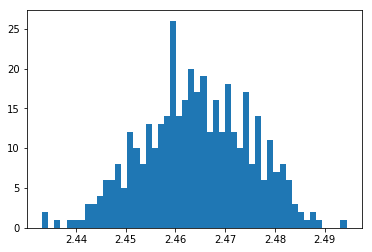

In [28]:
plt.hist(sigma_score, bins=50)

In [29]:
team_seasons = stan_params["team_seasons"]
team_periods = stan_params["team_periods"]

In [30]:
def get_team_path(tid, i=None):
    N = len(team_seasons)

    if i == None:
        i = random.randint(0, N-1)
    
    path = []
    for season in range(stan_data["nseasons"]):
        for period in range(stan_data["nperiods"]):
            path.append(team_seasons[i, tid, season] + team_periods[i, tid, season, period])
            
    return path

([<matplotlib.axis.XTick at 0x1236be358>,
 <a list of 7 Text xticklabel objects>)

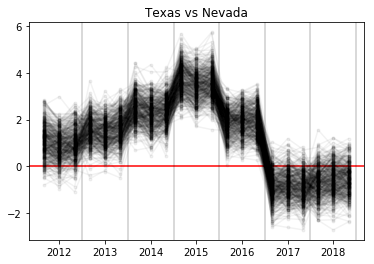

In [184]:
teamA = "Texas"
teamB = "Nevada"
tid = tid_to_id[name_to_tid[teamA]]
oid = tid_to_id[name_to_tid[teamB]]


f, ax = plt.subplots()

ax.axhline(0, color="red")

for trace in range(stan_iters):
    ax.plot([a-b for a, b in zip(get_team_path(tid, trace), get_team_path(oid, trace))], 
            ".-", color="black", alpha=0.05)
    
ax.set_title("{} vs {}".format(teamA, teamB))

for i in range(stan_data["nseasons"]):
    ax.axvline(2.5 + 3*i, color="black", alpha=0.2)
    
# set the locations of the xticks
year_ticks = [1+3*i for i in range(stan_data["nseasons"])]
plt.xticks( year_ticks )

# set the locations and labels of the xticks
plt.xticks( year_ticks,  [first_season+i for i in range(len(year_ticks))])


# Simulating the tournament

In [39]:
tournament_year = 2018

yr = tournament_year - first_season

In [50]:
tourny_teams = seeds[seeds.Season == tournament_year].TeamID.unique()
tourny_teams_ids = [tid_to_id[t] for t in tourny_teams]


# show top 10 teams
qualified_teams = sorted([(id_to_name(idx), get_team_path(idx)[3*yr + 2]) for idx in tourny_teams_ids],
                         key=lambda t: -t[1])

In [51]:
qualified_teams

[('Virginia', 5.020168570041779),
 ('Villanova', 4.778422191821651),
 ('Xavier', 4.425825350108769),
 ('North Carolina', 4.404049955190974),
 ('Cincinnati', 4.091733992661651),
 ('Arizona', 3.966750940992335),
 ('Tennessee', 3.9507947078259007),
 ('Duke', 3.9325688362884517),
 ('Texas Tech', 3.8844378336870373),
 ('Gonzaga', 3.798534187833207),
 ('Kentucky', 3.7584274359457703),
 ('West Virginia', 3.7395222638359757),
 ('Wichita St', 3.6306169512736917),
 ('Kansas', 3.5329764890411934),
 ('Davidson', 3.518649877203729),
 ('Purdue', 3.4809068456654035),
 ('Nevada', 3.4325818442696288),
 ('Auburn', 3.422525405076893),
 ('Clemson', 3.3686956131534083),
 ('Michigan St', 3.3166811348192278),
 ('Arkansas', 3.2953355287361568),
 ('Houston', 3.084461417101753),
 ('Creighton', 3.0586330742461016),
 ('Florida St', 3.026353555799618),
 ('Texas', 2.89929297862629),
 ('Rhode Island', 2.8159595503622805),
 ('Ohio St', 2.78841029468383),
 ('Florida', 2.7254108166983984),
 ('Michigan', 2.7220608838152

# Tournament simulation

In [52]:
tournament = slots[slots.Season == tournament_year][["Slot", "StrongSeed", "WeakSeed"]].set_index("Slot").to_dict("index")
# purge initial playoffs

tournament = {k: (v["StrongSeed"], v["WeakSeed"]) for k, v in tournament.items()}# if v["StrongSeed"][-1] != "a"}

In [53]:
initial = seeds[seeds.Season == tournament_year][["Seed", "TeamID"]].set_index("Seed").to_dict("index")

initial = {k: v["TeamID"] for k, v in initial.items()}# if k[-1] not in ["a", "b"]}

# initial["W11"] = 1425
# initial["W16"] = 1291
# initial["Y16"] = 1413
# initial["Z11"] = 1243

In [54]:
def simulate_game(A, B, trace):
    """
    Simulates game between teams A and B
    
    Returns: winner, loser, margin
    """
    yr = tournament_year - first_season
    idA = tid_to_id[A]
    idB = tid_to_id[B]
    
    # find team coefficients
    alpha_a = get_team_path(idA, trace)[3*yr+2]
    alpha_b = get_team_path(idB, trace)[3*yr+2]
    
    sqrt_score = random.gauss(alpha_a - alpha_b, sigma_score[trace])
    
    # return result
    if sqrt_score >= 0:
        return A, B, sqrt_score**2
    
    return B, A, sqrt_score**2

Checking whether simulations make sense. Win percentage seem a little conservative between number 1 and number 16 seed, which is normal for this type of model. The predicted scores are clearly over-dispersed; that is due to the square root. However, it shouldn't influence the simulations too much.

Simulating Virginia vs Villanova
Virginia wins 48.15%


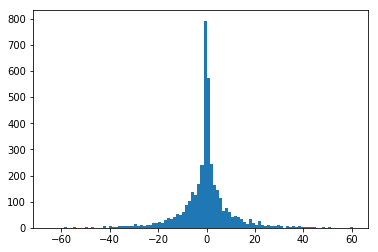

In [57]:
team_a = name_to_tid["Virginia"]
team_b = name_to_tid["Villanova"]
tid_to_name(team_a), tid_to_name(team_b)

raw_games = []
for _ in range(10):
    raw_games += [simulate_game(team_a, team_b, t) for t in range(stan_iters)]
    
final_scores = [(2*(a==team_a)-1) * score for a, b, score in raw_games]

print(f"Simulating {tid_to_name(team_a)} vs {tid_to_name(team_b)}")
a_win_perc = len([s for s in final_scores if s > 0]) / len(final_scores)
print(f"{tid_to_name(team_a)} wins {100*a_win_perc}%")

f = plt.hist(final_scores, bins=100, label="Final score")

In [58]:
def simulate_tournament(trace=0):
    results = {seed: team for seed, team in initial.items()}
    games = []
    
    for match, (teamA, teamB) in tournament.items():
        winner, loser, score = simulate_game(results[teamA], results[teamB], trace)
        results[match] = winner
        # round of game
        r = match[1]
        games.append((winner, loser, score, r))
    
    # clean initial seeds
    clean_results = {r: tid_to_name(winner)
            for r, winner in results.items() if r[0] == "R"}
    
    return clean_results, games

## Simulate a single tournament

In [63]:
results, games = simulate_tournament()

for tidA, tidB, score, rnd in games:
    print("Round {3}: {0:<20} def.    {1:<20}  {2}".format(tid_to_name(tidA), tid_to_name(tidB), int(score), rnd))

Round 1: UCLA                 def.    St Bonaventure        18
Round 1: Long Island          def.    Radford               13
Round 1: Arizona St           def.    Syracuse              23
Round 1: TX Southern          def.    NC Central            0
Round 1: Villanova            def.    Long Island           45
Round 1: Purdue               def.    CS Fullerton          15
Round 1: Texas Tech           def.    SF Austin             33
Round 1: Marshall             def.    Wichita St            0
Round 1: West Virginia        def.    Murray St             4
Round 1: Florida              def.    UCLA                  1
Round 1: Butler               def.    Arkansas              2
Round 1: Virginia Tech        def.    Alabama               2
Round 1: Kansas               def.    Penn                  16
Round 1: Duke                 def.    Iona                  14
Round 1: Michigan St          def.    Bucknell              9
Round 1: Auburn               def.    Col Charleston        0


# Simulate many tournaments

In [105]:
round_counters = defaultdict(Counter)
# (2, 2) prior
game_aggregator = defaultdict(lambda: (0, 0))

def update_aggregates(game_aggregator, games):
    for A, B, _, _ in games:
        winner = A
        a = min(A, B)
        b = max(A, B)
        wins_a, wins_b = game_aggregator[(a, b)]
        if a == winner:
            game_aggregator[(a, b)] = wins_a + 1, wins_b
        else:
            game_aggregator[(a, b)] = wins_a, wins_b+1

In [153]:
def perc_counter(cntr):
    total = sum(cntr.values())
    return sorted([(team, cnt/total) for team, cnt in cntr.items()], key=lambda x: -x[1])

In [226]:
for _ in range(50000):
    if itr % 1000 == 0:
        print(".", end="")
    trace = random.randint(0, stan_iters-1)
    sim, games = simulate_tournament(trace)
    update_aggregates(game_aggregator, games)
    for rnd, team in sim.items():
        round_counters[rnd].update([team]) 

In [227]:
percentages = {rnd: perc_counter(c) for rnd, c in round_counters.items()}

for rnd, outcome_teams in percentages.items():
    print("Round: {}".format(rnd))
    for team, perc in outcome_teams:
        print("{:>3.1f}% : {}".format(100*perc, team))
    print("-"*10)

Round: R1W1
98.2% : Villanova
1.5% : Radford
0.3% : Long Island
----------
Round: R1W2
94.4% : Purdue
5.6% : CS Fullerton
----------
Round: R1W3
83.0% : Texas Tech
17.0% : SF Austin
----------
Round: R1W4
85.3% : Wichita St
14.7% : Marshall
----------
Round: R1W5
77.9% : West Virginia
22.1% : Murray St
----------
Round: R1W6
58.5% : Florida
26.1% : UCLA
15.5% : St Bonaventure
----------
Round: R1W7
52.0% : Arkansas
48.0% : Butler
----------
Round: R1W8
54.5% : Virginia Tech
45.5% : Alabama
----------
Round: R1X1
90.5% : Kansas
9.5% : Penn
----------
Round: R1X2
93.8% : Duke
6.2% : Iona
----------
Round: R1X3
84.6% : Michigan St
15.4% : Bucknell
----------
Round: R1X4
76.4% : Auburn
23.6% : Col Charleston
----------
Round: R1X5
67.5% : Clemson
32.5% : New Mexico St
----------
Round: R1X6
62.4% : TCU
19.4% : Syracuse
18.2% : Arizona St
----------
Round: R1X7
56.6% : Rhode Island
43.4% : Oklahoma
----------
Round: R1X8
59.1% : Seton Hall
40.9% : NC State
----------
Round: R1Y1
97.4% : Vir

# Submission

In [228]:
sample_submission = pd.read_csv("data_2018/SampleSubmissionStage2.csv")
sample_submission.head()

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


In [229]:
prior = 25
preds = []
for idx, row in sample_submission.iterrows():
    _, a, b = row.ID.split("_")
    wa, wb = game_aggregator[(int(a), int(b))]
    prediction = (wa+prior) / (wa + wb + 2*prior)
    preds.append(("2018_{}_{}".format(a, b), prediction))


In [230]:
submission = pd.DataFrame(preds)
submission.columns = ["ID", "Pred"]

In [231]:
submission.head()

,ID,Pred
0,2018_1104_1112,0.454545
1,2018_1104_1113,0.508197
2,2018_1104_1116,0.392996
3,2018_1104_1120,0.421488
4,2018_1104_1137,0.508772


## Save csv

In [232]:
submission.to_csv("mens_2018_submission.csv", index=False)

In [171]:
team_a = "Virginia"
team_b = "Duke"

tid, oid = name_to_tid[team_a], name_to_tid[team_b]

wa, wb = game_aggregator[(min(tid, oid), max(tid, oid))]
if tid == min(tid, oid):
    print("{} beats {} with probability {:.2f}".format(team_a, team_b, wa / (wa+wb)))
else:
    print("{} beats {} with probability {:.2f}".format(team_b, team_a, wa / (wa+wb)))

Duke beats Virginia with probability 0.45


In [181]:
tid_to_name(1233)

'Iona'

In [179]:
submission.sort_values("Pred").tail()

,ID,Pred
565,2018_1153_1460,0.880420
969,2018_1199_1300,0.884354
992,2018_1199_1411,0.889571
1216,2018_1242_1335,0.903771
852,2018_1181_1233,0.937066


In [183]:
round_counters["R1W1"]

Counter({'Long Island': 110, 'Radford': 565, 'Villanova': 37325})

# Read predictions

In [97]:
preds = pd.read_csv("mens_2018_submission.csv")
preds.head()

,ID,Pred
0,2018_1104_1112,0.454545
1,2018_1104_1113,0.508197
2,2018_1104_1116,0.392996
3,2018_1104_1120,0.421488
4,2018_1104_1137,0.508772


In [98]:
seeds[seeds.Season == 2018].TeamID.unique()

array([1437, 1345, 1403, 1455, 1452, 1196, 1116, 1439, 1104, 1139, 1382,
       1417, 1293, 1267, 1372, 1168, 1254, 1347, 1242, 1181, 1277, 1120,
       1155, 1395, 1348, 1371, 1301, 1328, 1113, 1393, 1308, 1158, 1137,
       1233, 1335, 1438, 1153, 1397, 1112, 1246, 1274, 1305, 1166, 1243,
       1400, 1260, 1172, 1138, 1460, 1209, 1420, 1462, 1314, 1276, 1211,
       1326, 1222, 1401, 1281, 1199, 1344, 1361, 1355, 1422, 1285, 1252,
       1300, 1411])

In [119]:
playing_teams = [name for name, tid in name_to_tid.items() if tid in seeds[seeds.Season == 2018].TeamID.unique()]

def substr_count(s, search):
    N = len(search)
    return sum(s.lower().find(search[i:(i+2)]) != -1 for i in range(N-1))

def find_team(search):
    return max(playing_teams, key=lambda n: substr_count(n, search))

def find_prediction(team_a, team_b):
    ta = find_team(team_a)
    tb = find_team(team_b)
    id1 = name_to_tid[ta]
    id2 = name_to_tid[tb]
        
    if id1 < id2:
        game_id = "2018_{}_{}".format(id1, id2)
        p = preds[preds.ID == game_id].Pred.unique()[0]
    else:
        game_id = "2018_{}_{}".format(id2, id1)
        p = 1-preds[preds.ID == game_id].Pred.unique()[0]
    
    if p > 0.5:
        print("Predict {} to beat {} with probability {:.2f}".format(ta, tb, p))
    else:
        print("Predict {} to beat {} with probability {:.2f}".format(tb, ta, 1-p))

In [121]:
find_prediction("loyo", "miami")

Predict Miami FL to beat Loyola-Chicago with probability 0.54
